In [1]:
from pathlib import Path
from typing import Annotated

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import yaml
from pytask import Product

from caregiving.config import ROOT, SRC, BLD, JET_COLOR_MAP
from caregiving.model.shared import FEMALE, MALE

In [2]:
def table(df_col):
    return pd.crosstab(df_col, columns="Count")["Count"]

def statsmodels_params_to_dict(params, name_prefix, name_constant=None):
    """Turn statsmodels regression params object into dict.

    Args:
        params (pd.Series): Pandas Series containing the parameter names and values.
        name_constant (str): A custom string to use in the new name for 'const'.
        name_prefix (str): A custom prefix to prepend to all parameter names.

    Returns:
        dict: A dictionary with regression parameters.

    """
    name_constant = "" if name_constant is None else name_constant + "_"

    return {
        f"{name_prefix}_{(f'{name_constant}constant' if key == 'const' else key)}": val
        for key, val in params.items()
    }


In [3]:
def run_binary_logit(df, outcome, parent):
    """
    Estimate binary logit for parent's survival (0 or 1).
    """
    formula = (
        f"{parent}_{outcome} ~ {parent}_age + I({parent}_age**2) + "
        f"C({parent}_lagged_health)"
    )
    model_parent = smf.logit(formula, data=df).fit()
    print(f"Results for {parent} (Binary Logit)")
    print(model_parent.summary())
    return model_parent

def plot_variable_distribution(df, column_name):
    """
    Plots the distribution of a categorical or binary variable in a DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to plot.
    """
    counts = df[column_name].value_counts(dropna=False).sort_index()

    plt.figure(figsize=(6, 4))
    counts.plot(kind="bar")
    plt.title(f"Distribution of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

## 1) SHARE Data

In [4]:
path_to_raw_data = BLD / "data" / "estimation_data.csv"

path_to_save_parental_survival = (
    BLD / "estimation" / "stochastic_processes" / "parental_survival_params.csv"
)

In [5]:
df = pd.read_csv(path_to_raw_data)

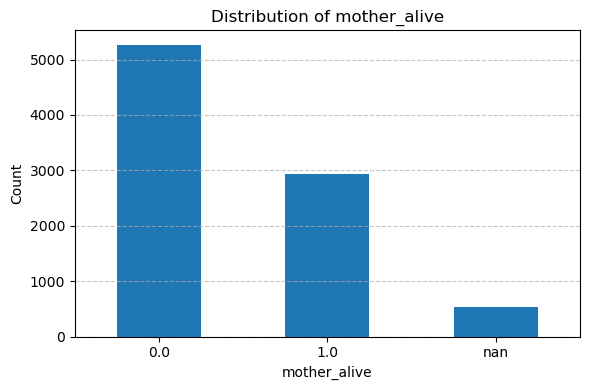

In [6]:
plot_variable_distribution(df, "mother_alive")

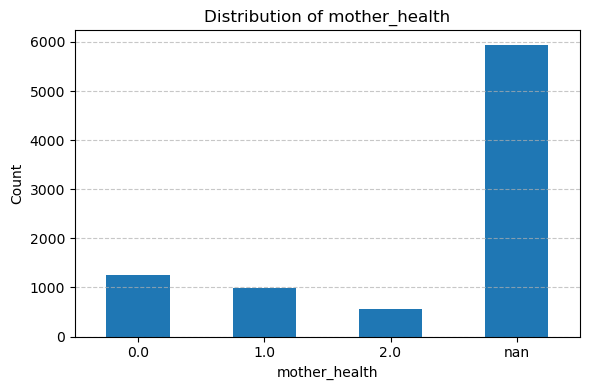

In [7]:
plot_variable_distribution(df, "mother_health")

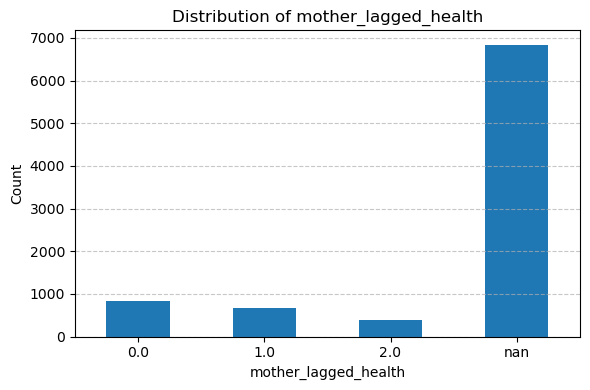

In [8]:
plot_variable_distribution(df, "mother_lagged_health")

In [9]:
table(df["mother_lagged_health"])

mother_lagged_health
0.0    844
1.0    676
2.0    379
Name: Count, dtype: int64

In [10]:
def _prepare_dependent_variables_health(data, health="health", age="age"):
    data = data.copy()

    data[f"father_{health}_good"] = np.where(
        data[f"father_{health}"] == 0,
        1,
        np.where(data[f"father_{health}"].isna(), np.nan, 0),
    )
    data[f"father_{health}_medium"] = np.where(
        data[f"father_{health}"] == 1,
        1,
        np.where(data[f"father_{health}"].isna(), np.nan, 0),
    )
    data[f"father_{health}_bad"] = np.where(
        data[f"father_{health}"] == 2,
        1,
        np.where(data[f"father_{health}"].isna(), np.nan, 0),
    )

    data[f"mother_{health}_good"] = np.where(
        data[f"mother_{health}"] == 1,
        1,
        np.where(data[f"mother_{health}"].isna(), np.nan, 0),
    )
    data[f"mother_{health}_medium"] = np.where(
        data[f"mother_{health}"] == 1,
        1,
        np.where(data[f"mother_{health}"].isna(), np.nan, 0),
    )
    data[f"mother_{health}_bad"] = np.where(
        data[f"mother_{health}"] == 2,
        1,
        np.where(data[f"mother_{health}"].isna(), np.nan, 0),
    )

    data[f"father_{age}_squared"] = data[f"father_{age}"] ** 2
    data[f"mother_{age}_squared"] = data[f"mother_{age}"] ** 2

    return data

In [11]:
dat = _prepare_dependent_variables_health(
    df,
    health="lagged_health",
    age="lagged_age",
)

In [12]:
x_mother_with_nans = sm.add_constant(
    dat[
        [
            "mother_lagged_age",
            "mother_lagged_age_squared",
            "mother_lagged_health_medium",
            "mother_lagged_health_bad",
        ]
    ],
)
x_mother = x_mother_with_nans.dropna()
data_mother = dat.dropna(
    subset=[
        "mother_lagged_age",
        "mother_lagged_age_squared",
        "mother_lagged_health_medium",
        "mother_lagged_health_bad",
    ],
)
x_female = x_mother[(data_mother["mother_alive"].notna())]
y_female = data_mother["mother_alive"][(data_mother["mother_alive"].notna())]
x_female = x_female.reset_index(drop=True)
y_female = y_female.reset_index(drop=True)

In [13]:
logit_female = sm.Logit(y_female, x_female).fit()

Optimization terminated successfully.
         Current function value: 0.350616
         Iterations 7


In [14]:
logit_female.params

const                         -18.635261
mother_lagged_age               0.641862
mother_lagged_age_squared      -0.004654
mother_lagged_health_medium    -0.492005
mother_lagged_health_bad       -1.608871
dtype: float64

In [15]:
params_mother = statsmodels_params_to_dict(
    logit_female.params,
    name_prefix="survival_prob",
    name_constant="mother",
)
params_mother

{'survival_prob_mother_constant': -18.635261219459725,
 'survival_prob_mother_lagged_age': 0.6418623035380162,
 'survival_prob_mother_lagged_age_squared': -0.0046541825825236385,
 'survival_prob_mother_lagged_health_medium': -0.49200470978549254,
 'survival_prob_mother_lagged_health_bad': -1.6088706724286093}

In [16]:
def compute_survival_prob(coefs, age, health_level):
    age_squared = age ** 2

    # One-hot encoding for health
    health_medium = 1 if health_level == 1 else 0
    health_bad = 1 if health_level == 2 else 0

    # logit = (
    #     coefs['intercept'] +
    #     coefs['age'] * age +
    #     coefs['age_squared'] * age_squared +
    #     coefs['health_medium'] * health_medium +
    #     coefs['health_bad'] * health_bad
    # )

    logit = (
        coefs["survival_prob_mother_constant"]
        + coefs["survival_prob_mother_lagged_age"] * age
        + coefs["survival_prob_mother_lagged_age_squared"] * age_squared
        + coefs["survival_prob_mother_lagged_health_medium"] * health_medium
        + coefs["survival_prob_mother_lagged_health_bad"] * health_bad
    )

    prob = 1 / (1 + np.exp(-logit))
    return prob

In [17]:
def plot_mother_survival_by_health(coefs, age_range=(60, 100)):
    """
    Plots the probability of mother being alive by age for three health levels (0: good, 1: medium, 2: bad).

    Parameters:
    - coefs (dict): Dictionary of logistic regression coefficients.
    - age_range (tuple): Range of ages to evaluate (inclusive).
    """

    # Prepare age range and labels
    ages = np.arange(age_range[0], age_range[1] + 1)
    health_labels = ["Good Health (0)", "Medium Health (1)", "Bad Health (2)"]

    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

    for i, health in enumerate([0, 1, 2]):
        probs = [compute_survival_prob(coefs, age, health) for age in ages]
        axes[i].plot(ages, probs)
        axes[i].set_title(f"Mother Survival Probability\n{health_labels[i]}")
        axes[i].set_xlabel("Age")
        axes[i].set_ylim(0, 1)
        axes[i].grid(True)

    axes[0].set_ylabel("Probability of Being Alive")
    plt.tight_layout()
    plt.show()

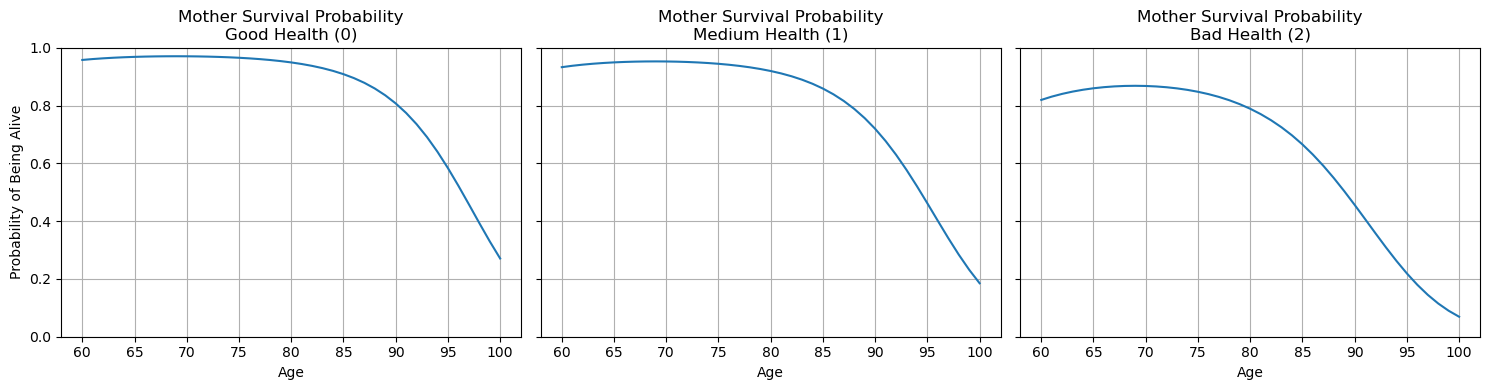

In [18]:
plot_mother_survival_by_health(params_mother)

## 2) Statistical Office Data

If you want the ex ante probability of being alive at a given age (i.e., the probability of surviving from birth through that age), you need the cumulative product of the age‐specific survival probabilities. In other words, the second approach—using cumprod()—is the correct one.

In [19]:
df = pd.read_csv(SRC / "data" / "statistical_office" / "12621-0001_Sterbetafel_clean.csv")


In [20]:
def plot_cumulative_survival(df, year, ages):
    """
    Plots cumulative survival probabilities for males and females in a given year over a specified age range.

    Parameters:
    - df: pandas DataFrame containing columns 'year', 'age', 'male_survival_probability', 'female_survival_probability'
    - year: int, the year for which the data should be filtered
    - ages: numpy array of ages over which to plot the cumulative survival probability
    """
    # Filter for the given year and age range
    df_filtered = df[(df["year"] == year) & (df["age"].isin(ages))].sort_values("age")

    # Calculate cumulative survival for males and females
    df_filtered["male_cumulative"] = df_filtered["male_survival_probability"].cumprod()
    df_filtered["female_cumulative"] = df_filtered["female_survival_probability"].cumprod()

    # Create plots side by side
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

    # Plot for males
    axes[0].plot(df_filtered["age"], df_filtered["male_cumulative"], marker="o", linestyle="-")
    axes[0].set_title(f"Male Cumulative Survival Probability in {year}")
    axes[0].set_xlabel("Age")
    axes[0].set_ylabel("Cumulative Share Alive")
    axes[0].grid(True, which="both", axis="both", linestyle="--", linewidth=0.5)

    # Plot for females
    axes[1].plot(df_filtered["age"], df_filtered["female_cumulative"], marker="o", linestyle="-")
    axes[1].set_title(f"Female Cumulative Survival Probability in {year}")
    axes[1].set_xlabel("Age")
    axes[1].grid(True, which="both", axis="both", linestyle="--", linewidth=0.5)

    plt.tight_layout()
    plt.show()

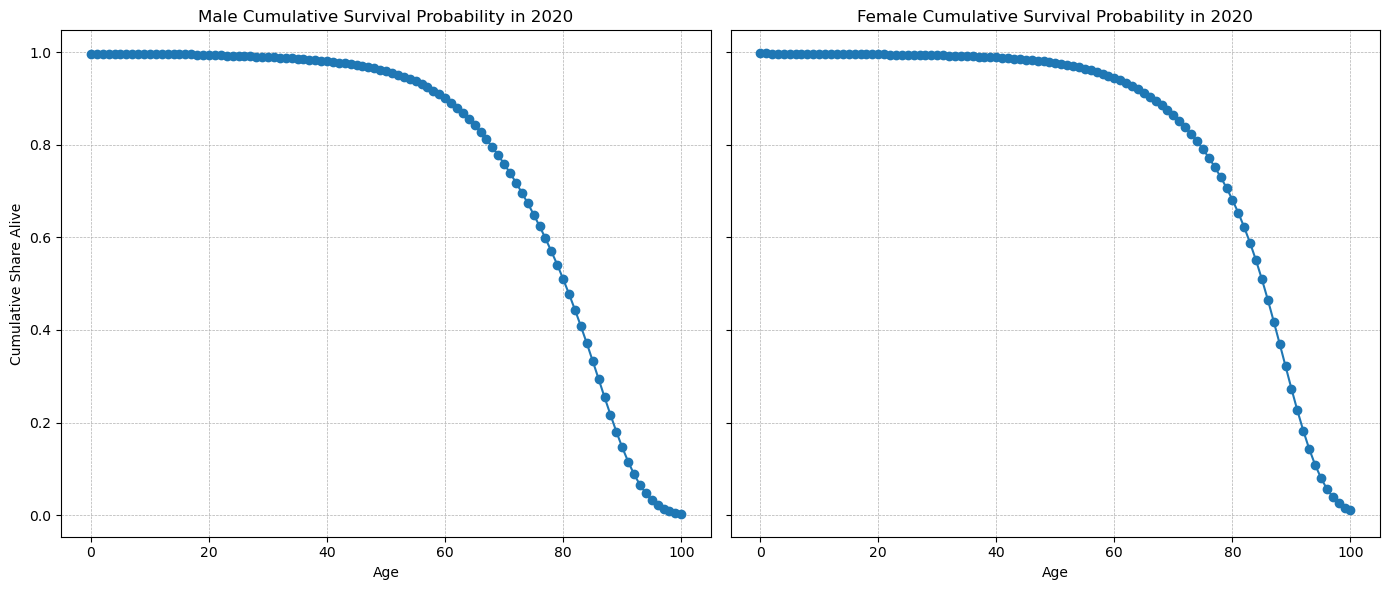

In [21]:
plot_cumulative_survival(df, year=2020, ages=np.arange(0, 101))

# 3) SOEP (Max & Bruno)

Kroll & Lampert (2009): 

Seit etwa 20 Jahren lässt sich ein ständig wachsendes Interesse der epidemiologischen Forschung und der Gesundheitsberichterstattung am Einfluss des sozioökonomischen Status auf die Gesundheit und Lebenserwartung feststellen. Mit der Sozialepidemiologie hat sich inzwischen eine eigene Fachrichtung etabliert, die sich schwerpunktmäßig mit der sozial ungleichen Verteilung von Gesundheitschancen und Krankheitsrisiken, die auch auf den Begriff der „gesundheitlichen Ungleichheit“ gebracht wird, befasst (Mielck & Bloomfield 2001). Die vorliegenden Studien zeigen in großer Überstimmung, dass Menschen mit niedrigem sozioökonomischen Status häufiger von Krankheiten, Beschwerden, Behinderungen und Unfallverletzungen betroffen sind, die eigene Gesundheit und gesundheitsbezogene Lebensqualität schlechter einschätzen und zu einem größeren Anteil vorzeitig sterben. Auch in Risiko- und Belastungsexpositionen, gesundheitsrelevanten Einstellungen und Verhaltensweisen sowie in der Bewältigung von Gesundheitsproblemen treten deutliche sozioökonomische Unterschiede hervor (Übersichten zum Forschungsstand z.B. bei Mielck 2000, 2005, Helmert 2003, Lampert et al. 2005).

In [22]:
specs = {
    "sex_labels": ["Men", "Women"],
    "education_labels": ["Low Education", "High Education"],
    "health_labels": ["Bad health", "Good health", "Death"],
    "start_age_mortality": 16,
    "end_age_mortality": 99,
    # We'll align final plot x-limits with the same 50..60 range:
    "start_age": 16,
    "end_age": 99,
}

JET_COLOR_MAP = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

In [23]:
mortality_transition_matrix_csv = pd.read_csv(
    ROOT / "src" / "sandbox" / "data" / "mortality_transition_matrix.csv"
)
path_to_mortality_transition_matrix_csv = (
    ROOT / "src" / "sandbox" / "data" / "mortality_transition_matrix.csv"
)

In [26]:
def plot_mortality(path_to_mortality_transition_matrix_csv, specs):
    """Plot mortality characteristics."""

    # Estimated mortality transition matrix
    estimated_mortality = pd.read_csv(path_to_mortality_transition_matrix_csv)

    # Health states
    alive_health_states = np.where(np.array(specs["health_labels"]) != "Death")[0]

    # Add columns for survival probabilities
    estimated_mortality["survival_prob_year"] = np.nan
    estimated_mortality["survival_prob"] = np.nan

    # Calculate survival probabilities by sex, health, education
    for sex_var, sex_label in enumerate(specs["sex_labels"]):
        for health in alive_health_states:
            for edu_var, edu_label in enumerate(specs["education_labels"]):
                mask = (
                    (estimated_mortality["sex"] == sex_var)
                    & (estimated_mortality["health"] == health)
                    & (estimated_mortality["education"] == edu_var)
                )
                subset = estimated_mortality.loc[
                    mask, ["death_prob", "age"]
                ].sort_values(by="age")

                # 1-year survival = 1 - death_prob
                subset["survival_prob_year"] = 1 - subset["death_prob"]
                # cumulative product across ages
                subset["survival_prob"] = subset["survival_prob_year"].cumprod()
                # shift so survival_prob at age=x is the survival up to the end of x
                subset["survival_prob"] = subset["survival_prob"].shift(1)

                # first row => survival prob = 1.0 at start
                if not subset.empty:
                    first_idx = subset.index[0]
                    subset.loc[first_idx, "survival_prob"] = 1.0

                # Update
                estimated_mortality.update(subset)

    # -------------------------------------------------------------
    # Plot the results in two subplots (Male vs. Female)
    # -------------------------------------------------------------
    fig, axes = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

    for sex_var, sex_label in enumerate(specs["sex_labels"]):
        ax = axes[sex_var]
        for edu_var, edu_label in enumerate(specs["education_labels"]):
            for health in alive_health_states:
                mask = (
                    (estimated_mortality["sex"] == sex_var)
                    & (estimated_mortality["health"] == health)
                    & (estimated_mortality["education"] == edu_var)
                )
                health_label = specs["health_labels"][health]

                # We'll do dashed line if health == 0 (Bad), solid if health == 1 (Good)
                linestyle = "--" if health == 0 else "-"

                ax.plot(
                    estimated_mortality.loc[mask, "age"],
                    estimated_mortality.loc[mask, "survival_prob"],
                    color=JET_COLOR_MAP[edu_var],
                    label=f"{edu_label}; {health_label}",
                    linestyle=linestyle,
                )

        ax.set_title(f"Estimated Survival Probability for {sex_label}")
        ax.set_xlabel("Age")
        ax.set_xlim(specs["start_age"], specs["end_age"] + 1)
        ax.set_ylabel("Survival Probability")
        ax.set_ylim(0, 1)

        # Add soft gridlines
        ax.grid(True, which="both", linestyle=":", linewidth=0.5, color="gray", alpha=0.5)

    # Show the legend in the left subplot
    axes[0].legend(loc="lower left")

    plt.tight_layout()
    # In your real code, you might save the figure:
    # fig.savefig(paths_dict["plots"] + "estimated_survival_probabilities.png")

    # For this demo, show inline:
    plt.show()

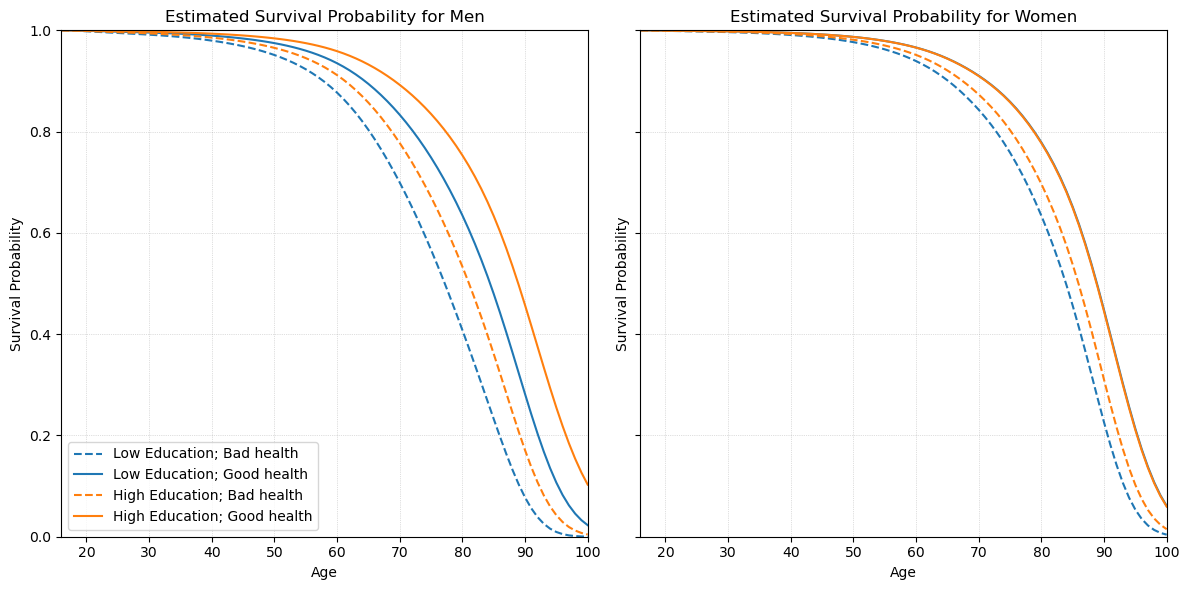

In [27]:
plot_mortality(path_to_mortality_transition_matrix_csv, specs)